<a href="https://colab.research.google.com/github/rafalopes74/EnergyConsumptionAI/blob/main/EnergyConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import load_model
from sklearn.metrics import accuracy_score


In [3]:
!pip install holidays --upgrade

     |████████████████████████████████| 172 kB 4.9 MB/s 
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2


In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import holidays
plt.style.use('ggplot')

In [5]:
!wget --no-clobber https://raw.githubusercontent.com/rafalopes74/EnergyConsumptionAI/main/DAYTON_hourly.csv


--2022-04-11 18:22:14--  https://raw.githubusercontent.com/rafalopes74/EnergyConsumptionAI/main/DAYTON_hourly.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3274443 (3.1M) [text/plain]
Saving to: ‘DAYTON_hourly.csv’

DAYTON_hourly.csv   100%[===================>]   3.12M  --.-KB/s    in 0.07s   

2022-04-11 18:22:14 (46.2 MB/s) - ‘DAYTON_hourly.csv’ saved [3274443/3274443]



In [6]:
data = pd.read_csv("/content/DAYTON_hourly.csv", header = 'infer', parse_dates = True)
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.set_index("Datetime")

#data.resample('3H').sum()
#data = data.resample('6H').sum()
data = data.resample('12H').sum()
#data.resample('1D').sum()
#data.resample('1W').sum()
#data.resample('1Y').sum()
#data.groupby([data.index.year == 2015,data.index.month <3 ])['DAYTON_MW'].sum()

In [7]:
data.shape

(10109, 1)

In [8]:
data.tail(5)

,DAYTON_MW
Datetime,
2018-08-01 00:00:00,22046.0
2018-08-01 12:00:00,27401.0
2018-08-02 00:00:00,22058.0
2018-08-02 12:00:00,29979.0
2018-08-03 00:00:00,2042.0


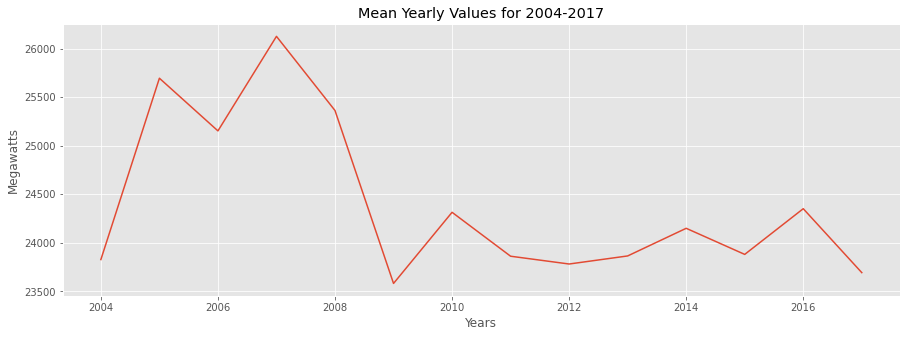

In [9]:
# YEARLY CONSUMPTIONS

mean_yearly_consumptions = []
years = []

for i in range(2004, 2018):
  mean_yearly_consumptions.append(data[data.index.year == i].mean())
  years.append(i)

plt.figure(figsize = (15, 5))
plt.plot(years, mean_yearly_consumptions)

plt.title("Mean Yearly Values for 2004-2017")
plt.xlabel("Years")
plt.ylabel("Megawatts")

plt.show()

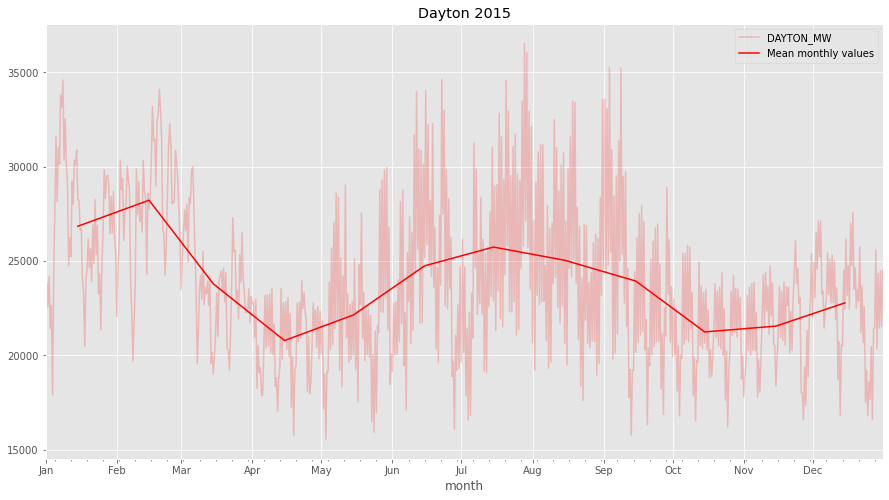

In [10]:
year_2015 = data[data.index.year == 2015]

month_mean_values = []
months = []
xticks = []
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in (range(1,13)):
    month_mean_values.append(year_2015[(year_2015.index.month == i)]['DAYTON_MW'].mean())
    months.append(datetime.datetime(2015, i, 15))
    xticks.append(datetime.datetime(2015, i, 1)) 

month = pd.DataFrame({'Mean monthly values': month_mean_values, 'month':months })
month = month.set_index('month')

base=year_2015.plot(color='red',alpha=0.20, figsize = (15, 8), title = 'Dayton 2015')
month.plot(color='red', alpha=1.0, ax=base)
plt.xticks(xticks, month_names)

plt.show()

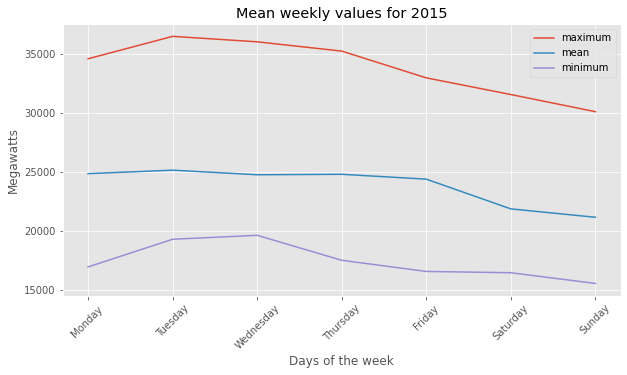

In [11]:
# VALUES BY WEEKDAY

mean_weekday = []
max_weekday = []
min_weekday = []
weekdays = ['Monday ', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i in range(0, 7):
  mean_weekday.append(data[(data.index.year == 2015) & (data.index.weekday == i)].mean())
  max_weekday.append( data[(data.index.year == 2015) & (data.index.weekday == i)].max())
  min_weekday.append( data[(data.index.year == 2015) & (data.index.weekday == i)].min())

plt.figure(figsize = (10, 5))
plt.plot(weekdays, max_weekday, weekdays, mean_weekday, weekdays, min_weekday)

plt.title('Mean weekly values for 2015')
plt.xlabel('Days of the week')
plt.ylabel('Megawatts')
plt.xticks(weekdays, rotation = 45)
plt.legend(['maximum', 'mean', 'minimum'])

plt.show()

In [12]:
"""
weekday = pd.DataFrame({'DAYTON_MW' : []})
weekend = []
public_holiday = []

ohio_holidays = holidays.country_holidays('US', subdiv='OH', years=2015)

for holiday in ohio_holidays:
  pd.concat( [weekday, data[(data.index.year == 2015) & (data.index.weekday < 5) & (data.index.date != holiday)]] )
  weekend.append(data[(data.index.year == 2015) & (5 <= data.index.weekday) & (data.index.weekday == 6)])
  public_holiday.append(data[(data.index.year == 2015) & (5 <= data.index.weekday) & (data.index.date == holiday)])

#print(data)
#plt.boxplot(list(weekday))
"""

"\nweekday = pd.DataFrame({'DAYTON_MW' : []})\nweekend = []\npublic_holiday = []\n\nohio_holidays = holidays.country_holidays('US', subdiv='OH', years=2015)\n\nfor holiday in ohio_holidays:\n  pd.concat( [weekday, data[(data.index.year == 2015) & (data.index.weekday < 5) & (data.index.date != holiday)]] )\n  weekend.append(data[(data.index.year == 2015) & (5 <= data.index.weekday) & (data.index.weekday == 6)])\n  public_holiday.append(data[(data.index.year == 2015) & (5 <= data.index.weekday) & (data.index.date == holiday)])\n\n#print(data)\n#plt.boxplot(list(weekday))\n"

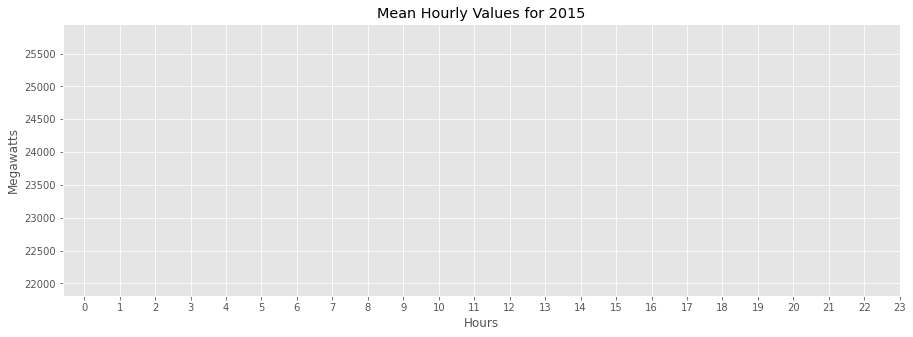

In [13]:
#           MEAN HOURLY VALUES

mean_hourly_values = []
hours = [x for x in range(0, 24)]

for i in range(0, 24):
  mean_hourly_values.append(data[(data.index.year == 2015) & (data.index.hour == i)].mean())

plt.figure(figsize = (15, 5))
plt.plot(hours, mean_hourly_values)

plt.title("Mean Hourly Values for 2015")
plt.xlabel("Hours")
plt.ylabel("Megawatts")
plt.xticks(hours)

plt.show()

Preprocessing

In [60]:
data = data[data.index.year >= 2012]

train, test = train_test_split(data[data.index.year >= 2012], test_size=0.2, shuffle = False)

scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(train)

len(train)
len(test)

963

In [34]:
# Reshaping.
ts_scaled_2 = ts_scaled.reshape(1,-1,1)             # (batch_size, time series length, n_input)

Hyperparameters

In [35]:
n_epochs = 100                   
batch_size = 1                    # There is only 1 time series data. No other choice but 1. 
learn_rate = 0.0002   

n_input = 1                       # Scalar input.
n_neurons = 10                   # N# of neurons per layer.
n_output = 1                      # Scalar output.

In [36]:
# RNN or LSTM network.
# return_sequnces = True: means "Sequence to Sequence".
# input_shape = (None, n_inputs) : variable length of the time series.
my_model = Sequential()
my_model.add(SimpleRNN(units=n_neurons,return_sequences=True, input_shape=(None, n_input)))     # RNN.
my_model.add(LSTM(units=n_neurons,return_sequences=True, input_shape=(None, n_input)))         # LSTM.
my_model.add(TimeDistributed(Dense(units=n_output, activation="linear")))    # Wrapper.

In [37]:
# View the summary.
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 10)          120       
                                                                 
 lstm_1 (LSTM)               (None, None, 10)          840       
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1)          11        
 tributed)                                                       
                                                                 
Total params: 971
Trainable params: 971
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Define the optimizer and compile.
my_optimizer=Adam(lr=learn_rate)
my_model.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [39]:
# No validation.
# CAUTION: y is X shifted by +1.
my_summary = my_model.fit(ts_scaled_2[:,:-1,:], ts_scaled_2[:,1:,:], epochs=n_epochs, batch_size = batch_size, verbose = 0)

In [85]:
#my_model.save('LSTM_model.h5')
#my_model = load_model('LSTM_model.h5')

In [41]:
my_summary.history.keys()

dict_keys(['loss', 'mse'])

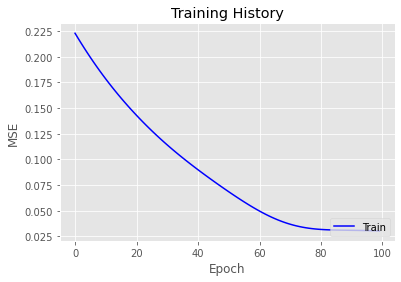

In [42]:
plt.plot(my_summary.history['mse'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

In [69]:
n_ts_seed = 400                                 # Seed length.
n_predict_time_steps = len(test)                    # Prediction length.

len(ts_scaled)

3850

In [70]:
# Prediction loop.
ts_seed = ts_scaled

for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1,-1,1)        # Reshape.     
    y_pred = my_model.predict(X)
    y_last= y_pred[0,-1,0]             # The last output is the predicted y.
    ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(1,1)), axis=0)

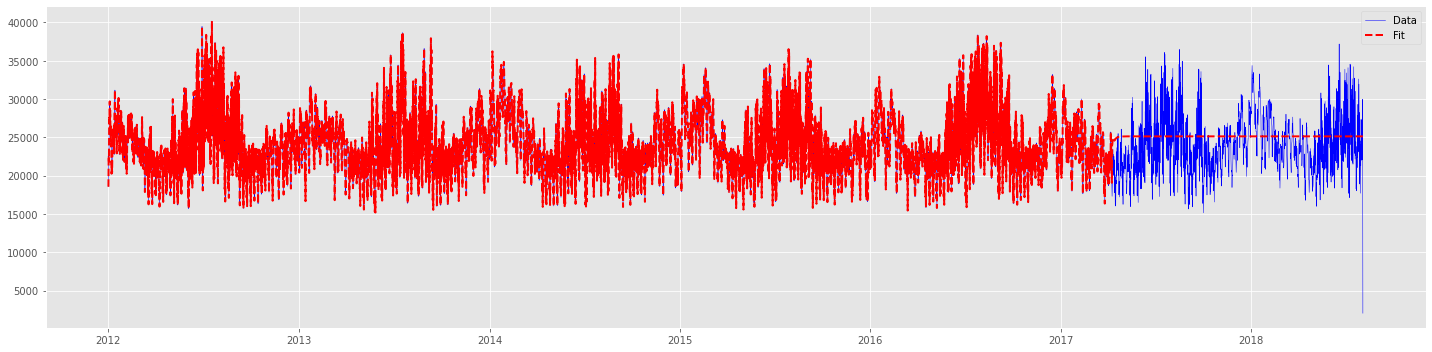

In [83]:
# Do the inverse transform and show the times series. 
ts = scaler.inverse_transform(ts_seed)
ts = ts.reshape(-1)
y = pd.DataFrame({'prediction' : ts}, index = data.iloc[:len(ts_scaled) + n_predict_time_steps].index)


plt.figure(figsize = (20, 5))
plt.plot(data.DAYTON_MW, c='b',linewidth=0.5, linestyle="-",label="Data")
plt.plot(y, c='r',linewidth=2, linestyle="--",label="Fit")

plt.legend()
plt.tight_layout()
plt.show()

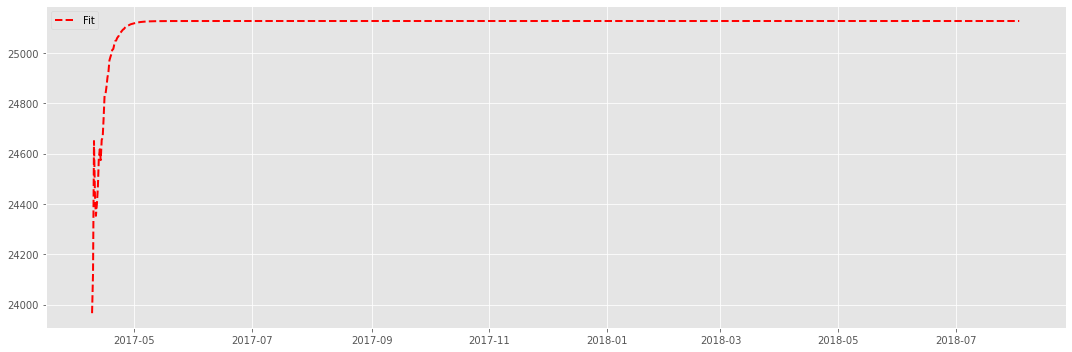

In [81]:
plt.figure(figsize = (15, 5))
#plt.plot(test, c='b',linewidth=0.5, linestyle="-",label="Data")
plt.plot(y[len(train):], c='r',linewidth=2, linestyle="--",label="Fit")


plt.legend()
plt.tight_layout()
plt.show()

In [97]:
#accuracy_score(train.DAYTON_MW, y[:len(train)].prediction)

Datetime
2012-01-01 00:00:00    18554.0
2012-01-01 12:00:00    22609.0
2012-01-02 00:00:00    21844.0
2012-01-02 12:00:00    27624.0
2012-01-03 00:00:00    26760.0
                        ...   
2017-04-06 12:00:00    25707.0
2017-04-07 00:00:00    23925.0
2017-04-07 12:00:00    23217.0
2017-04-08 00:00:00    20157.0
2017-04-08 12:00:00    19065.0
Freq: 12H, Name: prediction, Length: 3850, dtype: float64